<div class="alert alert-danger" style="color:black"><b>Running ML-LV Jupyter Notebooks:</b><br>
    <ol>
        <li>Make sure you are running all notebooks using the <code>adv_ai</code> kernel.
        <li><b>It is very important that you do not create any additional files within the weekly folders on CSCT cloud.</b> Any additional files, or editing the notebooks with a different environment may prevent submission/marking of your work.</li>
            <ul>
                <li>NBGrader will automatically fetch and create the correct folders files for you.</li>
                <li>All files that are not the Jupyter notebooks should be stored in the 'ML-LV/data' directory.</li>
            </ul>
        <li>Please <b>do not pip install</b> any python packages (or anything else). You should not need to install anything to complete these notebooks other than the packages provided in the Jupyter CSCT Cloud environment.</li>
    </ol>
    <b>If you would like to run this notebook locally you should:</b><br>
    <ol>
        <li>Create an environment using the requirements.txt file provided. <b>Any additional packages you install will not be accessible when uploaded to the server and may prevent marking.</b></li>
        <li>Download a copy  of the notebook to your own machine. You can then edit the cells as you wish and then go back and copy the code into/edit the ones on the CSCT cloud in-place.</li>
        <li><b>It is very important that you do not re-upload any notebooks that you have edited locally.</b> This is because NBGrader uses cell metadata to track marked tasks. <b>If you change this format it may prevent marking.</b></li>
    </ol>
</div>

# Practical 4: Recurrent Neural Networks

For most NLP problems the input representations consist of sequences of words (sentences, paragraphs, etc). The words in a sequence have a temporal relationship, or in other words, the *order* in which they appear changes the meaning of the sequence. In the previous practical we looked at several text classification methods which were unable to model this sequential relationship. Either because the algorithm processes all input features at once, or because the temporal relationship is lost through the chosen representation (BOW/TF-IDF), or both.

In contrast, RNN process each feature of an input example in turn, at each time-step. So each word of an input sequence is processed and used to update an internal *hidden state*, or memory, of the network. Thus RNN are able to capture temporal relationships between each feature of an input example. For this reason RNN are frequently used form many NLP tasks, such as classification and language modelling.

In the first part of this practical we will apply an RNN (LSTM) to the task of sentiment classification on the IMDB dataset. We will use word embedding representations for each word in the input sequence.

In the second part of this practical we will explore various different configurations for RNN models, including bi-directional and stacked (or deep) RNNs. We will also use [Comet ML](https://www.comet.com/site/) to record results and compare different models and hyperparameter configurations.

The objectives of this practical are:
1. Understand the key concepts for applying RNN to NLP tasks, specifically input representations and shape

2. Consider different RNN configurations and output modes, including returning sequences, or only the last hidden state, bi-directional and stacked RNN

3. Compare and contrast different hyperparameters and models, making use of ML platforms, like [Comet ML](https://www.comet.com/site/) , to record and present results

# 1 LSTM for Sentiment Classification

## 1.0 Import libraries

In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'  # Suppress Tensorflow messages
import spacy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from gensim.models import Word2Vec
import tensorflow as tf
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, ConfusionMatrixDisplay
%matplotlib inline

# Get the status of NBgrader (for skipping cell execution while validating/grading)
grading = True if os.getenv('NBGRADER_EXECUTION') else False

# Set seaborn style for matplotlib plots
plt.style.use('seaborn-v0_8-white')

# Get the project directory (should be in ML-LV)
path = ''
while os.path.basename(os.path.abspath(path)) != 'ML-LV':
    path = os.path.abspath(os.path.join(path, '..'))

# Set the directory to the data folder (should be in ML-LV/data/imdb)
data_dir = os.path.join(path, 'data', 'imdb')

# Set the directory to the shared dataset folder (should be in shared/datasets/imdb)
dataset_dir = os.path.join(path, '..', 'shared', 'datasets', 'imdb')

# Set the directory to the shared models folder (should be in shared/models/imdb)
model_dir = os.path.join(path, '..', 'shared', 'models', 'imdb')

# Load the Spacy language model ('en_core_web_md' should be in shared/models/spacy)
nlp = spacy.load(os.path.join(path, '..', 'shared', 'models', 'spacy'))

## 1.1 Load and pre-process data

1. First load the full IMDB dataset and our smaller reviews set.

2. Then we need to convert the 'positive' and 'negative' class labels to numerical values, 1 for positive and 0 for negative. Using the pandas `get_dummies` function creates two binary valued columns and then the `drop_first` parameter collapses these into a single column.

In [2]:
# Load the imdb dataset
imdb_data = pd.read_csv(os.path.join(dataset_dir, 'imdb_dataset.csv'))

# Load your imdb reviews
imdb_reviews = pd.read_csv(os.path.join(data_dir, 'imdb_reviews.csv'))

# Convert the sentiment to a binary value
imdb_data['sentiment'] = pd.get_dummies(imdb_data['sentiment'], drop_first=True)
imdb_reviews['sentiment'] = pd.get_dummies(imdb_reviews['sentiment'], drop_first=True)

imdb_data.head()

,review,sentiment
0,one of the other reviewers has mentioned that ...,1
1,a wonderful little production the filming tech...,1
2,i thought this was a wonderful way to spend ti...,1
3,basically there is a family where a little boy...,0
4,petter mattei s love in the time of money is a...,1


### Plot sequence lengths

Plot the distribution of review lengths in terms of number of tokens. This is important for RNN models because each token of an input review will be processed in turn, and so each input example will be a different length. Padding each review to the length of the longest in the data will increase processing time and may impact performance, so the distribution allows us to choose a suitable `max_seq_len` for the model to process. It looks like most reviews are less than 250 in length, so ~150 to 250 should be a suitable `max_seq_len`.

Mean sequence length: 235.67788
Median sequence length: 177.0
Max sequence length: 2498


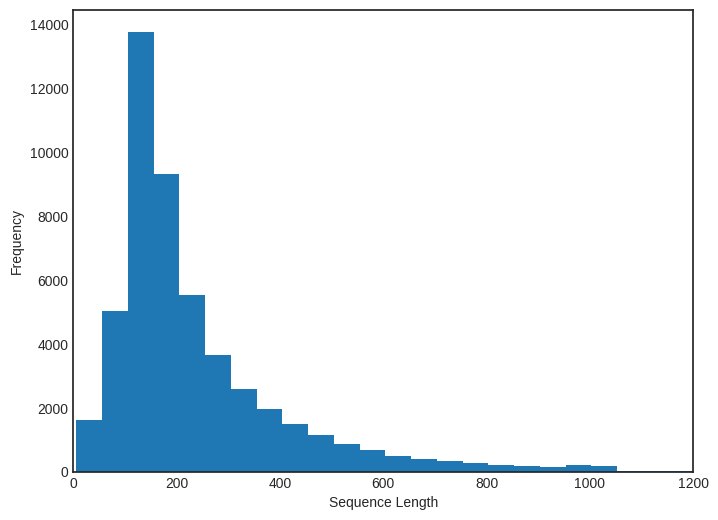

In [3]:
# Tokenise the reviews
tokenised_data = imdb_data['review'].apply(lambda x: [token.text for token in nlp.tokenizer(x)])

# Get the sequence lengths
seq_lengths = [len(review) for review in tokenised_data]

print(f'Mean sequence length: {np.mean(seq_lengths)}')
print(f'Median sequence length: {np.median(seq_lengths)}')
print(f'Max sequence length: {np.max(seq_lengths)}')

# Plot the distribution of review lengths
fig, ax = plt.subplots(figsize=(8, 6))
ax.hist(seq_lengths, bins=50)
ax.set_xlim(0, 1200)
ax.set_xlabel('Sequence Length')
ax.set_ylabel('Frequency')
plt.show()

### Load the vocabulary

A vocabulary has been created from the larger IMDB dataset, so lets load that and set the vocabulary size accordingly.

In [4]:
# Load the vocabulary file and store each word in a list
with open(os.path.join(dataset_dir, 'imdb_vocab.txt'), 'r') as file:
    imdb_vocab = file.read().splitlines() 

# Set the vocab size
vocab_size = 2000
imdb_vocab = imdb_vocab[:vocab_size -2]

# Print the vocabulary
print(f"Vocabulary size: {len(imdb_vocab)}")
for i, word in enumerate(imdb_vocab[:50]):
    print(f'({str(i)}, {word})', end=' ')

Vocabulary size: 1998
(0, the) (1, and) (2, a) (3, of) (4, is) (5, to) (6, it) (7, in) (8, i) (9, this) (10, that) (11, not) (12, was) (13, as) (14, movie) (15, for) (16, with) (17, but) (18, film) (19, you) (20, on) (21, are) (22, have) (23, s) (24, he) (25, his) (26, one) (27, be) (28, all) (29, at) (30, they) (31, by) (32, an) (33, who) (34, so) (35, from) (36, like) (37, there) (38, or) (39, do) (40, just) (41, her) (42, out) (43, about) (44, if) (45, has) (46, what) (47, can) (48, would) (49, some) 

### Process and vectorise the text

We will be using embedding representations as input to the RNN model, so each word in an input review needs to be mapped to an embedding vector. To do this we must first map each word to an integer according to its index within the vocabulary and then use that as a 'lookup' for the corresponding embedding. The result will be a 2D matrix/tensor of shape (`max_seq_len`, `embedding_dim`) for each input example. However, performing these steps manually beforehand results in a very large input tensor! So we will take advantage of the [TextVectorisation](https://www.tensorflow.org/api_docs/python/tf/keras/layers/TextVectorization) layer and [Embedding](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Embedding) layer in Keras.

1. We will split the data as normal, using the full IMDB data as training and validation and our reviews as a test set.

2. Set up the text vectorisation layer with our vocabulary and specified `max_seq_len`. This layer takes a string input, tokenises each word, maps to integers and then outputs a sequence of the specified length. Note: this layer also adds some special padding (`''`) and unknown (`'[UNK]'`) tokens. The padding token is used to pad the sequences up to the maximum sequence length (if they are too short), so that we can create batches of similar sized inputs. The unknown token is used to replace words that are not in the vocabulary.

In [5]:
# Set the maximum sequence length
max_seq_len = 200

# Get the reviews
X = imdb_data['review'].values
print(f'Shape of X: {X.shape}')
print(X[:5])

# Get the class labels
y = imdb_data['sentiment'].values
print(f'Shape of y: {y.shape}')
print(y[:5])

# Split the data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Get the test data
X_test = imdb_reviews['review'].values
y_test = imdb_reviews['sentiment'].values

# Create the text vectoriser
vectorise_layer = layers.TextVectorization(
    standardize=None,
    split='whitespace',
    output_mode='int',
    output_sequence_length=max_seq_len,
    pad_to_max_tokens=False,
    vocabulary=imdb_vocab
)

# Vocabulary size and content should be the same as above + 2 for the padding token and OOV token
print(f'\nVectoriser vocabulary size: {len(vectorise_layer.get_vocabulary())}')
print(vectorise_layer.get_vocabulary()[:50])

# Show the vectorisation of a review
vectorised_review = vectorise_layer(X[0])
print(f'\nVectorised review:\n{vectorised_review}')

# Decode the vectorised review
decoded_review = [vectorise_layer.get_vocabulary()[i] for i in vectorised_review]
print(f'\nDecoded review:\n{decoded_review}')

Shape of X: (50000,)
['one of the other reviewers has mentioned that after watching just 1 oz episode you will be hooked they are right as this is exactly what happened with me the first thing that struck me about oz was its brutality and unflinching scenes of violence which set in right from the word go trust me this is not a show for the faint hearted or timid this show pulls no punches with regards to drugs sex or violence its is hardcore in the classic use of the word it is called oz as that is the nickname given to the oswald maximum security state penitentary it focuses mainly on emerald city an experimental section of the prison where all the cells have glass fronts and face inwards so privacy is not high on the agenda them city is home to many aryans muslims gangstas latinos christians italians irish and more so scuffles death stares dodgy dealings and shady agreements are never far away i would say the main appeal of the show is due to the fact that it goes where other shows w

### Create an embedding matrix

We need to create an embedding matrix of shape (`vocab_size`, `embedding_dim`). This will be the 'lookup' table for each word in an input sequence to be mapped to its embedding. We will the embeddings tuned on the IMDB data from last week as these should already contain information about the word relations they were trained on.

1. Create a numpy embedding matrix by looping over the vocabulary and assigning each word an embedding.

2. Then create an embedding layer using the embedding matrix as the lookup. This layer takes a `max_seq_len` sequence of integers as input and maps each word to an embedding to produce a tensor of shape (`max_seq_len`, `embedding_dim`).

In [6]:
# Set the embedding dimension
embedding_dim = 50

# Load the word embeddings
w2v_model = Word2Vec.load(os.path.join(model_dir, 'imdb_w2v.model'))

# Generate the embedding matrix
embedding_matrix = np.zeros((vocab_size, embedding_dim))
for i, word in enumerate(imdb_vocab):
    if word in w2v_model.wv.key_to_index:
        embedding_matrix[i] = w2v_model.wv.get_vector(word)[:embedding_dim]
        
# Show the embedding matrix
print(f"Shape of embeddings: {embedding_matrix.shape}")
print(embedding_matrix)

# Create the embedding layer
embedding_layer = layers.Embedding(
    input_dim=vocab_size,
    output_dim=embedding_dim,
    embeddings_initializer=tf.keras.initializers.Constant(embedding_matrix),
    mask_zero=True)

# Show the vectorisation and embedding of a review
vectorised_review = vectorise_layer(X[0])
embedded_review = embedding_layer(vectorised_review)
print(f'Shape of embedded review: {embedded_review.shape}')

# Show the embedding weights
embed_weights = embedding_layer.get_weights()[0]
print(f'Shape of embedding weights: {embed_weights.shape}')

Shape of embeddings: (2000, 50)
[[ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 ...
 [-0.00894076 -0.12877092 -0.04895075 ...  0.14032619  0.10201658
   0.34646019]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]]
Shape of embedded review: (200, 50)
Shape of embedding weights: (2000, 50)


## 1.2 Build the RNN model

The cell below creates a Keras functional model:
- The input layer takes a batch of single strings.

- Vectorisation layer tokenises and maps each word to integers.

- Embedding layer maps each sequence of words to embeddings. Each token in the sequence, of size `embedding_dim`, then becomes the input for the RNN at each timestep.

- RNN (LSTM) processes each word in the sequence in turn. Here, because `return_sequences=False` we are taking the last hidden state as the encoded sequence representation.

- Finally a feed forward layer performs classification.

In [7]:
# Input layer takes in a string
inputs = tf.keras.Input(shape=(1,), dtype=tf.string)

# Vectorise the inputs
vectorised_inputs = vectorise_layer(inputs)

# Embed the inputs
embedded_inputs = embedding_layer(vectorised_inputs)

# Recurrent layer
lstm_layer = layers.LSTM(32, return_sequences=False)(embedded_inputs)

# Classification layer
outputs = layers.Dense(1, activation="sigmoid")(lstm_layer)

# Compile the model
model = tf.keras.Model(inputs=inputs, outputs=outputs, name="LSTM")
model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])
model.summary()

Model: "LSTM"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ text_vectorization  │ (None, 200)       │          0 │ input_layer[0][0] │
│ (TextVectorization) │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding           │ (None, 200, 50)   │    100,000 │ text_vectorizati… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ not_equal           │ (None, 200)       │          0 │ text_vectorizati… │
│ (NotEqual)          │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm (LSTM)         │ (None, 32)        │     10,624 │ embedding[0][0],  │
│                     │                   │            │ not_equal[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 1)         │         33 │ lstm[0][0]        │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 110,657 (432.25 KB)

 Trainable params: 110,657 (432.25 KB)

 Non-trainable params: 0 (0.00 B)

### Train and evaluate the model

Epoch 1/5
313/313 ━━━━━━━━━━━━━━━━━━━━ 22s 66ms/step - accuracy: 0.5988 - loss: 0.6512 - val_accuracy: 0.8094 - val_loss: 0.4194
Epoch 2/5
313/313 ━━━━━━━━━━━━━━━━━━━━ 20s 64ms/step - accuracy: 0.8306 - loss: 0.3946 - val_accuracy: 0.8483 - val_loss: 0.3478
Epoch 3/5
313/313 ━━━━━━━━━━━━━━━━━━━━ 20s 65ms/step - accuracy: 0.8619 - loss: 0.3346 - val_accuracy: 0.8586 - val_loss: 0.3366
Epoch 4/5
313/313 ━━━━━━━━━━━━━━━━━━━━ 20s 65ms/step - accuracy: 0.8695 - loss: 0.3167 - val_accuracy: 0.8585 - val_loss: 0.3227
Epoch 5/5
313/313 ━━━━━━━━━━━━━━━━━━━━ 20s 65ms/step - accuracy: 0.8717 - loss: 0.3074 - val_accuracy: 0.8637 - val_loss: 0.3185
313/313 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step
Validation Accuracy: 0.8637


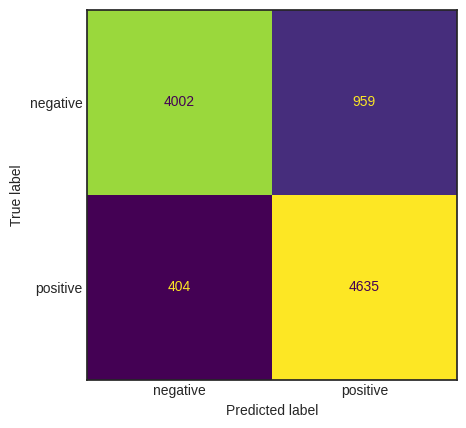

In [8]:
if not grading:
    # Fit the model
    results = model.fit(X_train, y_train, epochs=5, batch_size=128, validation_data=(X_val, y_val))
    
    # Predict class labels for validation set
    predictions = model.predict(X_val)
    predictions = [0 if x < 0.5 else 1 for x in predictions]  # Convert probabilities to binary
    print(f'Validation Accuracy: {accuracy_score(y_val, predictions)}')
    
    # Print confusion matrix
    conf_matrix = ConfusionMatrixDisplay.from_predictions(y_val, predictions, display_labels=['negative', 'positive'], colorbar=False)
    plt.show()


### Evaluate the model on your IMDB reviews

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
Test Accuracy: 0.61


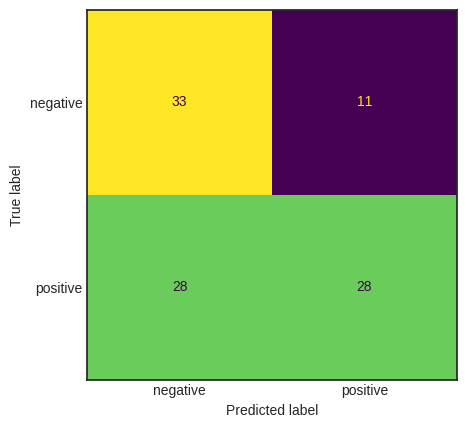

In [9]:
if not grading:
    # Predict class labels for test set
    predictions = model.predict(X_test)
    predictions = [0 if x < 0.5 else 1 for x in predictions]  # Convert probabilities to binary
    print(f'Test Accuracy: {accuracy_score(y_test, predictions)}')
    
    # Print confusion matrix
    conf_matrix = ConfusionMatrixDisplay.from_predictions(y_test, predictions, display_labels=['negative', 'positive'], colorbar=False)
    plt.show()

<div class="alert alert-info" style="color:black"><h2>1.3 Exercise: RNN architectures</h2>

As discussed in the lecture, there are several different architectural variations of RNN models, such as Bi-directional and stacked layers. You can use the Keras [Bi-directional layer](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Bidirectional) to convert the uni-directional LSTM into bi-directional. To stack two LSTM layers the first will need to output sequences (`return_sequences=True`), which become the inputs for the second layer. Then you can either take the last hidden state as output (as we did before), or pool the sequence of outputs.

1. In the following cell complete the `build_model()` function. It should take in the following arguments and return a Keras functional model:
    - `input_data` is the training set (for adapting the vectoriser layer).
    - `max_seq_len` is the maximum sequence length.
    - `embed_matrix` is the pre-computed embedding matrix.
    - `units` is the number of units in the recurrent layer.
    - `bi_direction` is whether to use a bi-directional recurrent layer.
    - `stacked` is whether to stack two recurrent layers.
    - `n_class` is the number of classes to predict, or the shape of the output layer.
    - `optimiser` is the optimiser to use.
    - `lr` is the learning rate for the optimiser.

2. You will need to use the [adapt()](https://www.tensorflow.org/api_docs/python/tf/keras/layers/TextVectorization#adapt) method on the vectorisation layer instead of explicitly setting a vocabulary.

3. You should make sure your function creates an LSTM based model with all of the possible combinations (4) for bi-directionality and stacked architectures, or neither.

4. You can manually create an optimiser using the [get()](https://www.tensorflow.org/api_docs/python/tf/keras/optimizers/get) function to retrieve an optimiser by its name. Then manually set its learning rate.

3. Once all the layers are implemented the function should compile the model with the given optimiser and return it.

<b>MARKS AVAILABLE: 5</b>
<br>
<b>MO1</b>
</div>

In [10]:
def build_model(input_data, max_seq_len, embed_matrix, units=32, bi_dir=False, stacked=False, n_class=1, optimiser='adam', lr=0.001):
    """Builds a LSTM model with the given parameters.
    
    Arguments:
        input_data (np.array): The training set inputs
        max_seq_len (int): The maximum sequence length
        embed_matrix (np.array): An embedding matrix
        units (int): The number of LSTM units
        bi_dir (bool): Whether to use a bidirectional LSTM
        stacked (bool): Whether to use a stacked LSTM
        n_class (int): The number of classes to predict
        optimiser (str): The optimiser to use
        lr (str): The optimiser learning rate to use
    """
    # YOUR CODE HERE
    # Input layer
    inputs = tf.keras.Input(shape=(1,), dtype=tf.string)

    # Vectorization layer
    vectorize_layer = layers.TextVectorization(
        standardize=None,
        split='whitespace',
        output_mode='int',
        output_sequence_length=max_seq_len,
        max_tokens=embed_matrix.shape[0] - 2  # OOV tokens
    )
    vectorize_layer.adapt(input_data)
    vectorized = vectorize_layer(inputs)

    # Embedding layer
    embedding_layer = layers.Embedding(
        input_dim=embed_matrix.shape[0],
        output_dim=embed_matrix.shape[1],
        embeddings_initializer=tf.keras.initializers.Constant(embed_matrix),
        mask_zero=True
    )
    embedded = embedding_layer(vectorized)

    # LSTM layers
    x = embedded
    if stacked:
        # First LSTM layer returns sequences for the next layer
        if bi_dir:
            lstm = layers.Bidirectional(layers.LSTM(units, return_sequences=True))
        else:
            lstm = layers.LSTM(units, return_sequences=True)
        x = lstm(x)

        # Second LSTM layer returns only the last output
        if bi_dir:
            lstm = layers.Bidirectional(layers.LSTM(units, return_sequences=False))
        else:
            lstm = layers.LSTM(units, return_sequences=False)
        x = lstm(x)
    else:
        # Single LSTM layer
        if bi_dir:
            lstm = layers.Bidirectional(layers.LSTM(units, return_sequences=False))
        else:
            lstm = layers.LSTM(units, return_sequences=False)
        x = lstm(x)

    # Output layer
    outputs = layers.Dense(n_class, activation='sigmoid')(x)

    # Create and compile the model
    model = tf.keras.Model(inputs=inputs, outputs=outputs)
    opt = tf.keras.optimizers.get(optimiser)
    opt.learning_rate = lr
    model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])
    
    return model

In [11]:
# Test cell (3 marks)

# Create a model using the build_model function
seq_len = 100
embed_dim = 50
embed_matrix = np.random.rand(2000, embed_dim)
model = build_model(X_train, seq_len, embed_matrix, units=32, bi_dir=False, stacked=False, n_class=1, optimiser='adam', lr=0.001)

# Test the model is a functional model
assert str(type(model)) == "<class 'keras.src.models.functional.Functional'>", 'Model should be a Functional Model'

# Test the number of layers
assert len(model.layers) == 5, 'Model should have 5 layers'

# Test the size of the input shape
assert model.input_shape == (None, 1), 'Input shape should be (None, 1)'

# Test the sequence length and embedding dimension
assert model.layers[2].output.shape == (None, seq_len, embed_dim), f'Embedding layer output shape should be (None, {seq_len}, {embed_dim})'

# Test the number of units
assert model.layers[3].units == 32, 'LSTM layer should have 32 units'

# Test the lstm is not bidirectional
assert not isinstance(model.layers[3], layers.Bidirectional), 'LSTM layer should not be bidirectional'

# Test the classification layer
assert model.layers[4].units == 1, 'Classification layer should have 1 unit'

# Test the optimiser
assert isinstance(model.optimizer, tf.keras.optimizers.Adam), 'Model should use the Adam optimiser'

# Test the learning rate
assert model.optimizer.learning_rate == 0.001, 'Model should use a learning rate of 0.001'

print('All tests passed!')

All tests passed!


In [ ]:
# Hidden test cell (2 marks)
# Tests all parameters of the build_model function including the bidirectional and stacked LSTM options


<div class="alert alert-success" style="color:black"><h3>Before you submit this notebook to NBGrader for marking:</h3> 

1. Make sure have completed all exercises marked by <span style="color:blue">**blue cells**</span>.
2. For automatically marked exercises ensure you have completed any cells with `# YOUR CODE HERE`. Then click 'Validate' button above, or ensure all cells run without producing an error.
3. For manually marked exercises ensure you have completed any cells with `"YOUR ANSWER HERE"`.
4. Ensure all cells are run with their output visible.
5. Fill in your student ID (**only**) below.
6. You should now **save and download** your work.

</div>

**Student ID:** 15006280
